In [1]:
import numpy as np
import scipy.io as sio 
import math
import matplotlib.pyplot as plt
from ntfmodel import *
from utils import *

##########################################################################-----
# Load hsi in matlab format
datapath = '../../MATLAB/ComponentAnalysisExperiments/data/'
filenames = [
    'h01-samson',
    'h02-jasper',
    'h03-urban',
    'h03-urban6',
    'h04-cuprite']

parms = LrModelParameters()
parms.lrate = 0.001
parms.MaxDelta = 1e-8
parms.RegWeight = 0.
parms.AscWeight = 0.

AbundanceThreshold = 0.95
AbundanceFromTarget = False
trials = range(1)



h01-samson
[I,J,K]=>[95,95,156]   [Lr,R]=>[19,3]
MaxDelta: 1e-08 LRate: 0.001 RegNorm: 1.0 RegWeight: 0.0 AscWeight: 0.0
Reorder: [1 2 0] | 5.895e-04 | 5.895e-04 | 5.895e-04 | 9.994e-09 |  239.0 |   36


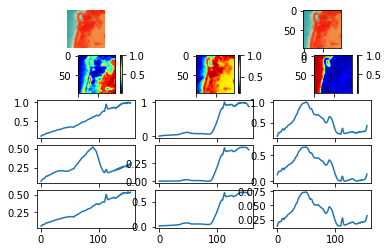

Trial: 1 sad:  0.0211  0.0314  0.0339 aavg: 0.0288  rmse:  0.0529  0.0329  0.0226 ravg: 0.0361


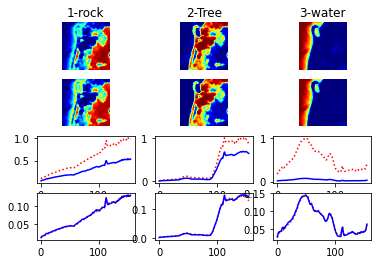

C:\Users\wilo_\anaconda3\envs\tf-gpu\lib\site-packages\scipy\io\matlab\mio.py:224: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


h02-jasper
[I,J,K]=>[100,100,198]   [Lr,R]=>[12,4]
MaxDelta: 1e-08 LRate: 0.001 RegNorm: 1.0 RegWeight: 0.0 AscWeight: 0.0
Reorder: [2 0 3 1] 2.777e-03 | 2.777e-03 | 2.777e-03 | 9.965e-09 |  218.2 |   42


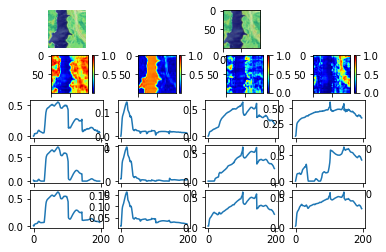

Trial: 1 sad:  0.0338  0.2064  0.1550  0.0575 aavg: 0.1132  rmse:  0.0719  0.0420  0.0690  0.0544 ravg: 0.0593


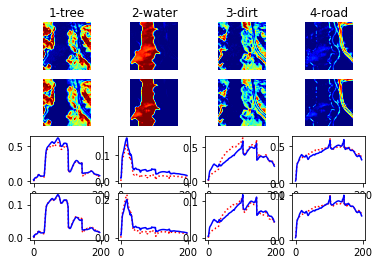

C:\Users\wilo_\anaconda3\envs\tf-gpu\lib\site-packages\scipy\io\matlab\mio.py:224: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


h03-urban
[I,J,K]=>[307,307,162]   [Lr,R]=>[145,4]
MaxDelta: 1e-08 LRate: 0.001 RegNorm: 1.0 RegWeight: 0.0 AscWeight: 0.0
Reorder: [2 3 0 1] 1.587e-03 | 1.587e-03 | 1.587e-03 | 9.371e-09 |   63.4 |  235


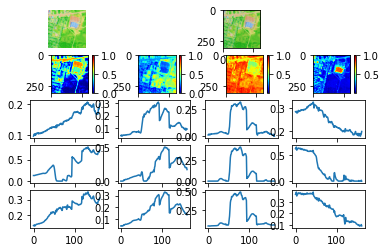

Trial: 1 sad:  0.0717  0.2783  0.0597  0.2106 aavg: 0.1551  rmse:  0.1097  0.1515  0.1724  0.0629 ravg: 0.1241


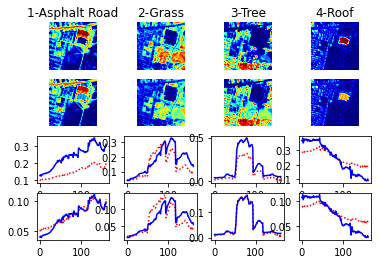

C:\Users\wilo_\anaconda3\envs\tf-gpu\lib\site-packages\scipy\io\matlab\mio.py:224: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


h03-urban6
[I,J,K]=>[307,307,162]   [Lr,R]=>[96,6]
MaxDelta: 1e-08 LRate: 0.001 RegNorm: 1.0 RegWeight: 0.0 AscWeight: 0.0
Reorder: [2 5 0 3 1 4]65e-03 | 1.365e-03 | 1.365e-03 | 9.593e-09 |   64.4 |  206


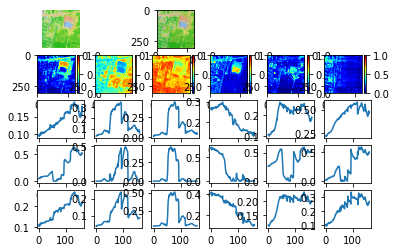

Trial: 1 sad:  0.0744  0.2576  0.1131  0.1536  0.0682  0.0805 aavg: 0.1246  rmse:  0.1418  0.1492  0.1583  0.0522  0.1314  0.1472 ravg: 0.1300


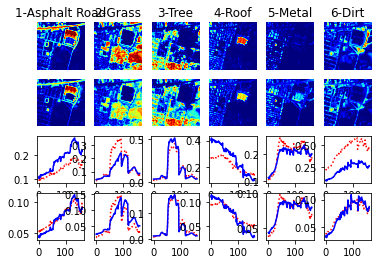

C:\Users\wilo_\anaconda3\envs\tf-gpu\lib\site-packages\scipy\io\matlab\mio.py:224: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


h04-cuprite
[I,J,K]=>[250,190,188]   [Lr,R]=>[27,12]
MaxDelta: 1e-08 LRate: 0.001 RegNorm: 1.0 RegWeight: 0.0 AscWeight: 0.0


In [ ]:
#for fn,Lr in zip(filenames,lowranks):
for fn in filenames:
    #for Lr in lowranks:
        matdict = sio.loadmat(datapath + fn)
        Y = matdict['hsiten']
        Sgt = matdict['Sgt']
        Sname = matdict['Sname']
        # R = 6
        # Sgt = np.random.uniform(size=(Y.shape[2],R))

        ### L-inf Normalized on mode-2
        Y = Y/np.max(Y)
        NormType = np.inf
        Ynorm = np.linalg.norm(Y, ord=NormType, axis=2, keepdims=True)
        Y=Y/Ynorm
        
        [I,J,K] = Y.shape
        [K,R] = Sgt.shape
        Lr = np.math.floor(np.maximum(I,J)**2/(R*K))
        print(fn)
        print(f'[I,J,K]=>[{I},{J},{K}]   [Lr,R]=>[{Lr},{R}]')
        parms.prnt()

        for i in trials:
            # Instanciate Model
            model = LrModel(Y,Lr,R,seed=i,parms=parms)
            model.run_optimizer()
            # Compute endmembers using spatial components
            # and reconstructed tensor

            Sprime = get_endmembers(model, AbundanceThreshold,
                norms=Ynorm, fromtarget=AbundanceFromTarget)
            (Sprime,p) = reorder(Sprime,Sgt)
            print(f'Reorder: {p}')
            plot_decomposition(model,Sgt,Sprime,p)
            plt.show()

            # Compute Fully Constrained Least Squares 
            A = fcls_np(Y,Sprime)
            Agt = read_agt(matdict)
            nx = math.floor(matdict['nx'])
            mtx = compute_metrics(i,Sgt, Sprime, A, Agt)
            # plot_abundance(Agt,A,nx)
            plot_all(Agt,A,nx,model,Sgt,Sprime,p,Sname)
            plt.show()
